# Quantum Phase Estimation (QPE) for H₂ — **Noisy**

- Uses PennyLane and your harmonized project utilities
- Adds simple noise models (depolarizing and amplitude damping)
- Compares to Hartree–Fock (HF)
- Includes sweeps over noise strengths

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import sys, os, json
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from qpe.qpe_utils import (
    plot_qpe_distribution,
    hartree_fock_energy,
    signature_hash,
    run_qpe,
    save_qpe_result,
    load_qpe_result,
    save_qpe_plot,
    ensure_dirs,
    set_seed,
)

# Set random seed and ensure directories exist
set_seed(0)
ensure_dirs()

# Define H₂ molecule (bond length ~0.7414 Å, STO-3G)
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])  # Å
basis = "STO-3G"

# Molecular Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=0, basis=basis
)

# Hartree–Fock reference occupation
electrons = 2
hf = qchem.hf_state(electrons, num_qubits)

print(f"Molecule: H₂  |  Basis: {basis}")
print(f"Number of qubits: {num_qubits}")
print(f"HF bitstring: {'|' + ''.join(str(b) for b in hf) + '⟩'}")


Molecule: H₂  |  Basis: STO-3G
Number of qubits: 4
HF bitstring: |1100⟩


In [2]:
# Core QPE parameters
molecule_name = "H2"
n_ancilla = 4      # Ancilla qubits for QPE register
t_evol = 1.0       # Evolution time in U = exp(-i*H*t)
trotter_steps = 2  # Trotterization depth
shots = 1000       # Sampling shots

# Noise configuration
noise_params = {
    "p_dep": 0.01,  # Depolarizing probability per application (per wire)
    "p_amp": 0.00,  # Amplitude damping probability per application (per wire)
}
print("Noise params:", noise_params)


Noise params: {'p_dep': 0.01, 'p_amp': 0.0}


In [3]:
# Build a unique signature so results cache separately per noise/params
sig = signature_hash(
    molecule=molecule_name,
    n_ancilla=n_ancilla,
    t=t_evol,
    noise=noise_params,
    shots=shots,
)

cached = load_qpe_result(molecule_name, sig)

if cached:
    print("✅ Loaded cached **noisy** QPE result.")
    result = cached
else:
    print("▶️ Running **noisy** QPE simulation...")
    result = run_qpe(
        hamiltonian=hamiltonian,
        hf_state=hf,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params=noise_params,
        shots=shots,
        molecule_name=molecule_name,
    )
    save_qpe_result(result)

# Display results
print("\n✅ QPE completed (noisy).")
print(f"Most probable state: {result['best_bitstring']}")
print(f"Estimated phase: {result['phase']:.6f}")
print(f"Estimated energy: {result['energy']:.8f} Ha")


✅ Loaded cached **noisy** QPE result.

✅ QPE completed (noisy).
Most probable state: 0100
Estimated phase: 0.125000
Estimated energy: -0.78539816 Ha


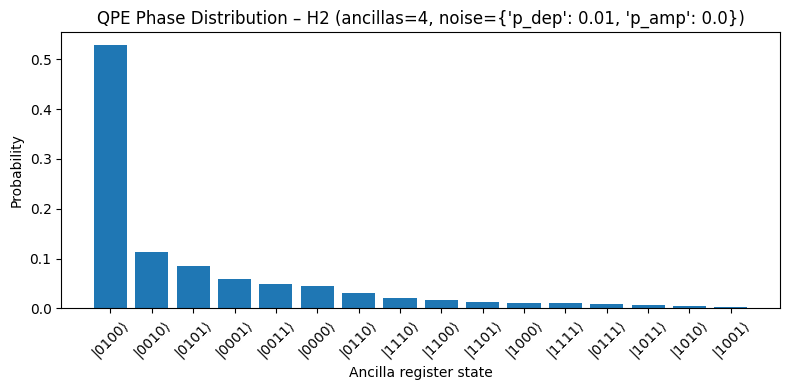

Saved plot → /workspaces/Variational_Quantum_Eigensolver/data/qpe/images/H2_QPE_4q.png


In [4]:
# Plot QPE distribution
plot_qpe_distribution(result)


In [5]:
# Compare with Hartree–Fock energy
E_hf = hartree_fock_energy(hamiltonian, hf)
print(f"Hartree–Fock energy: {E_hf:.8f} Ha")
print(f"QPE (noisy) estimate: {result['energy']:.8f} Ha")
print(f"ΔE (QPE - HF): {result['energy'] - E_hf:+.8f} Ha")


Hartree–Fock energy: -0.88842304 Ha
QPE (noisy) estimate: -0.78539816 Ha
ΔE (QPE - HF): +0.10302488 Ha


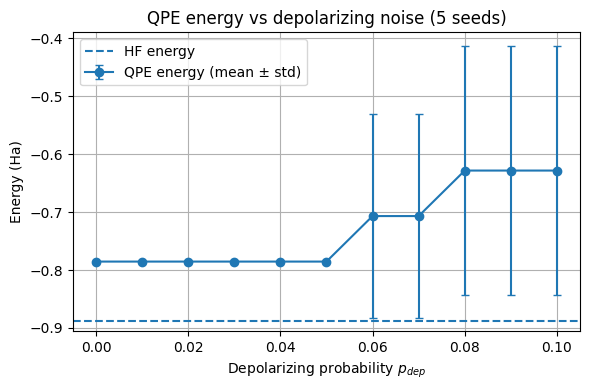

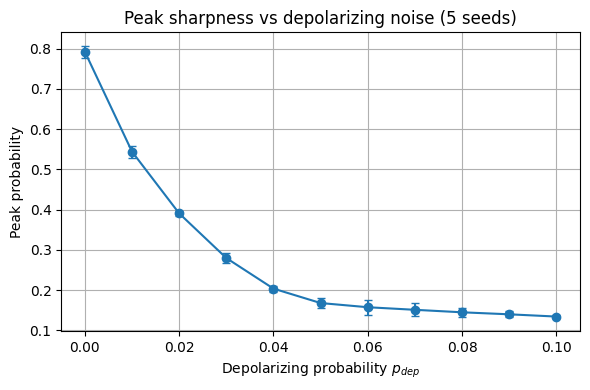

In [6]:
# Multi-seed depolarizing sweep (mean ± std)
p_dep_list = np.linspace(0.0, 0.1, 11)
seeds = np.arange(0, 5)

energies_mean, energies_std = [], []
peak_mean, peak_std = [], []

for p in p_dep_list:
    Es, Ps = [], []
    for seed in seeds:
        set_seed(seed)
        nparams = {"p_dep": float(p), "p_amp": 0.0, "seed": int(seed)}
        sig = signature_hash(molecule_name, n_ancilla, t_evol, nparams, shots)
        cached = load_qpe_result(molecule_name, sig)
        if cached:
            r = cached
        else:
            r = run_qpe(
                hamiltonian=hamiltonian, hf_state=hf, n_ancilla=n_ancilla,
                t=t_evol, trotter_steps=trotter_steps, noise_params=nparams,
                shots=shots, molecule_name=molecule_name
            )
            save_qpe_result(r)
        Es.append(r["energy"])
        Ps.append(r["probs"][r["best_bitstring"]])

    Es = np.array(Es)
    Ps = np.array(Ps)
    energies_mean.append(Es.mean())
    energies_std.append(Es.std(ddof=1))
    peak_mean.append(Ps.mean())
    peak_std.append(Ps.std(ddof=1))

energies_mean = np.array(energies_mean)
energies_std = np.array(energies_std)
peak_mean = np.array(peak_mean)
peak_std = np.array(peak_std)

# Plot energy with error bars
plt.figure(figsize=(6,4))
plt.errorbar(p_dep_list, energies_mean, yerr=energies_std, fmt='o-', capsize=3, label='QPE energy (mean ± std)')
plt.axhline(E_hf, linestyle='--', label='HF energy')
plt.xlabel('Depolarizing probability $p_{dep}$')
plt.ylabel('Energy (Ha)')
plt.title(f'QPE energy vs depolarizing noise ({len(seeds)} seeds)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(save_qpe_plot(f"{molecule_name}_QPE_Dep_Energy_avg.png"), dpi=200)
plt.show()

# Plot peak probability with error bars
plt.figure(figsize=(6,4))
plt.errorbar(p_dep_list, peak_mean, yerr=peak_std, fmt='o-', capsize=3)
plt.xlabel('Depolarizing probability $p_{dep}$')
plt.ylabel('Peak probability')
plt.title(f'Peak sharpness vs depolarizing noise ({len(seeds)} seeds)')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_qpe_plot(f"{molecule_name}_QPE_Dep_Peak_avg.png"), dpi=200)
plt.show()


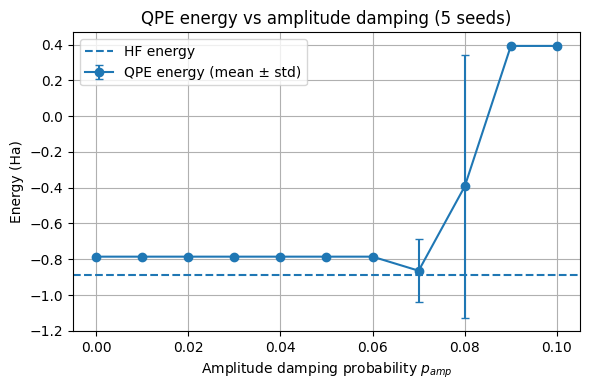

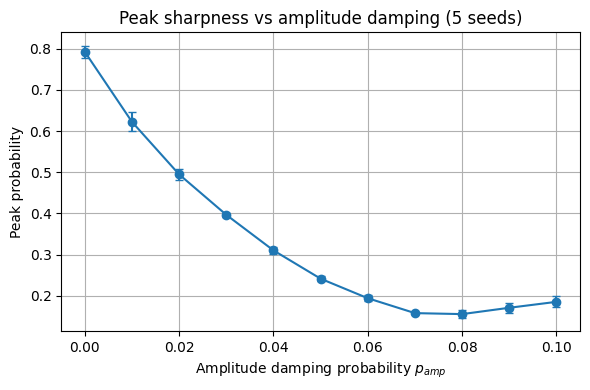

In [7]:
# Multi-seed amplitude damping sweep (mean ± std)
# Same seeds as before
p_amp_list = np.linspace(0.0, 0.1, 11)

energies_mean, energies_std = [], []
peak_mean, peak_std = [], []

for p in p_amp_list:
    Es, Ps = [], []
    for sd in seeds:
        set_seed(sd)
        nparams = {"p_dep": 0.0, "p_amp": float(p), "seed": int(sd)}
        sig = signature_hash(molecule_name, n_ancilla, t_evol, nparams, shots)
        cached = load_qpe_result(molecule_name, sig)
        if cached:
            r = cached
        else:
            r = run_qpe(
                hamiltonian=hamiltonian, hf_state=hf, n_ancilla=n_ancilla,
                t=t_evol, trotter_steps=trotter_steps, noise_params=nparams,
                shots=shots, molecule_name=molecule_name
            )
            save_qpe_result(r)
        Es.append(r["energy"])
        Ps.append(r["probs"][r["best_bitstring"]])

    Es = np.array(Es)
    Ps = np.array(Ps)
    energies_mean.append(Es.mean())
    energies_std.append(Es.std(ddof=1))
    peak_mean.append(Ps.mean())
    peak_std.append(Ps.std(ddof=1))

energies_mean = np.array(energies_mean)
energies_std = np.array(energies_std)
peak_mean = np.array(peak_mean)
peak_std = np.array(peak_std)

# Plot energy with error bars
plt.figure(figsize=(6,4))
plt.errorbar(p_amp_list, energies_mean, yerr=energies_std, fmt='o-', capsize=3, label='QPE energy (mean ± std)')
plt.axhline(E_hf, linestyle='--', label='HF energy')
plt.xlabel('Amplitude damping probability $p_{amp}$')
plt.ylabel('Energy (Ha)')
plt.title(f'QPE energy vs amplitude damping ({len(seeds)} seeds)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(save_qpe_plot(f"{molecule_name}_QPE_Amp_Energy_avg.png"), dpi=200)
plt.show()

# Plot peak probability with error bars
plt.figure(figsize=(6,4))
plt.errorbar(p_amp_list, peak_mean, yerr=peak_std, fmt='o-', capsize=3)
plt.xlabel('Amplitude damping probability $p_{amp}$')
plt.ylabel('Peak probability')
plt.title(f'Peak sharpness vs amplitude damping ({len(seeds)} seeds)')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_qpe_plot(f"{molecule_name}_QPE_Amp_Peak_avg.png"), dpi=200)
plt.show()
